,Method,Correlation,P-Value
0,Pearson,-0.738,2.1e-18
1,Spearman,-0.798,3.0e-23
2,Kendall,-0.602,3.5e-18


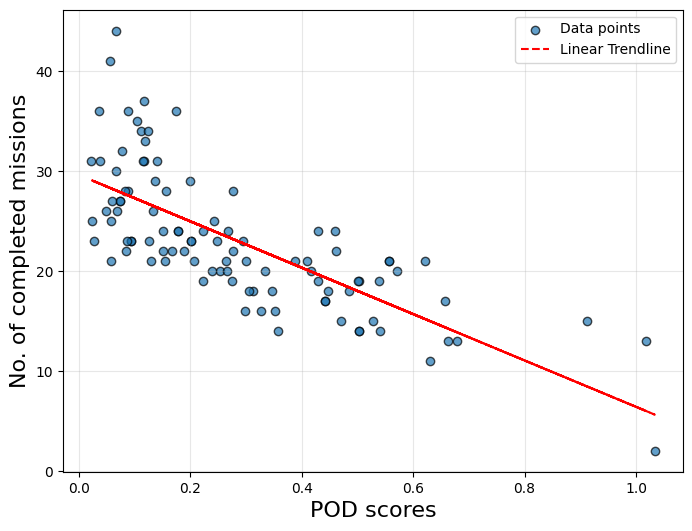

,Method,Correlation,P-Value
0,Pearson,-0.718,4.0e-17
1,Spearman,-0.786,3.8e-22
2,Kendall,-0.598,7.8e-18


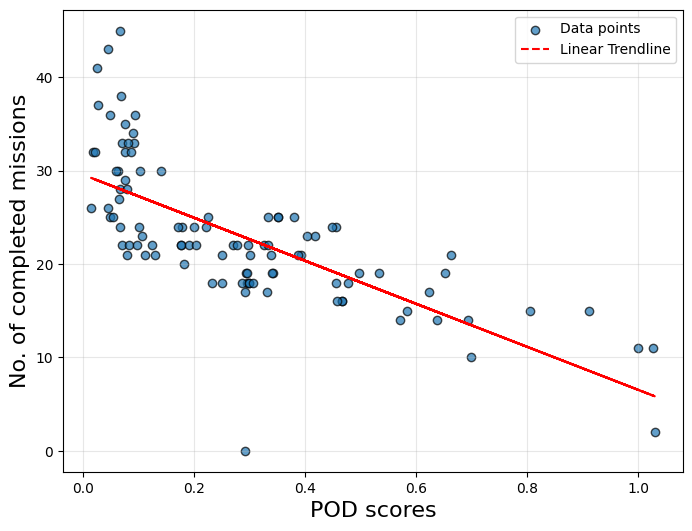

,Method,Correlation,P-Value
0,Pearson,-0.740,1.3e-18
1,Spearman,-0.830,1.5e-26
2,Kendall,-0.634,4.8e-20


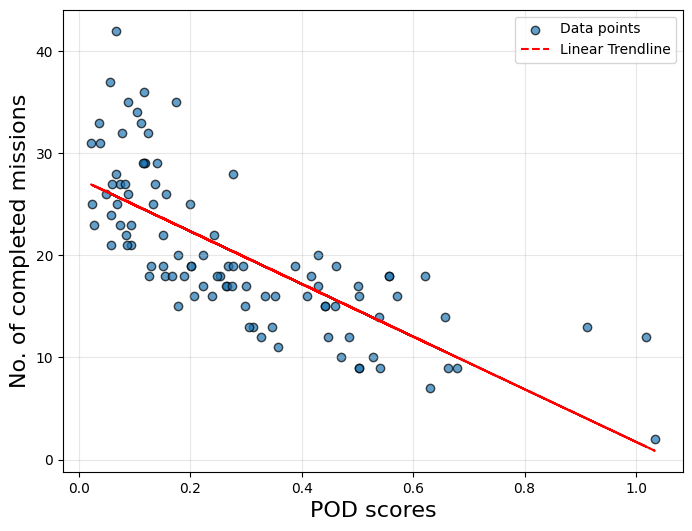

,Method,Correlation,P-Value
0,Pearson,-0.681,6.2e-15
1,Spearman,-0.769,1.0e-20
2,Kendall,-0.575,8.6e-17


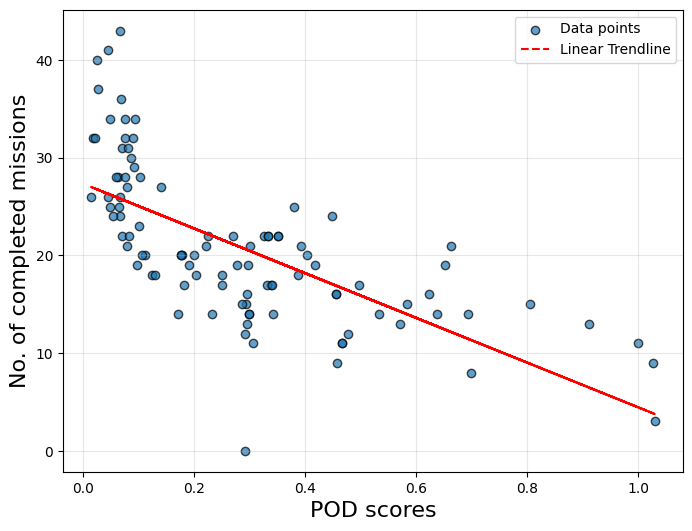

,Method,Correlation,P-Value
0,Pearson,0.391,5.8e-05
1,Spearman,0.593,8.2e-11
2,Kendall,0.437,2.5e-10


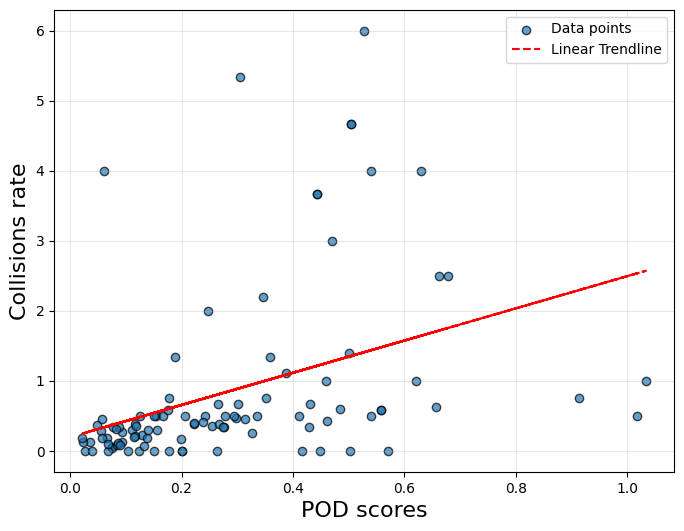

,Method,Correlation,P-Value
0,Pearson,0.154,1.3e-01
1,Spearman,0.376,1.2e-04
2,Kendall,0.281,4.6e-05


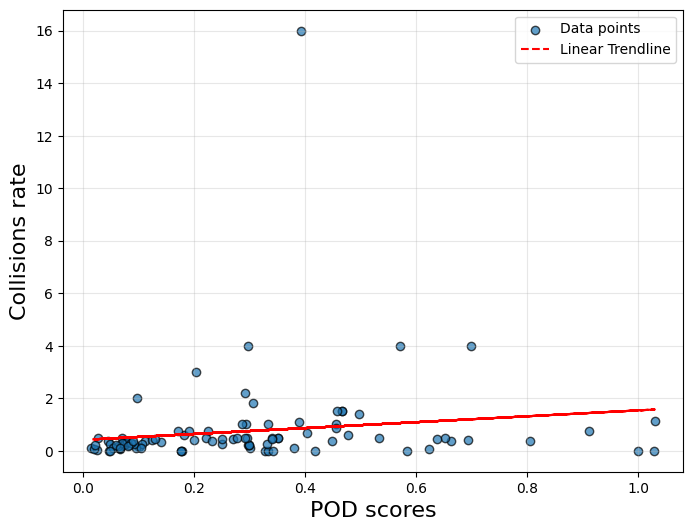

Maps with low connectivity (slowness: baseline; coordination strategies): baseline
Maps with low connectivity (slowness: baseline; coordination strategies): change of priorities
Maps with low connectivity (slowness: baseline; coordination strategies): stops
Maps with low connectivity (slowness: without rerouting; coordination strategies): baseline
Maps with low connectivity (slowness: without rerouting; coordination strategies): change of priorities
Maps with low connectivity (slowness: without rerouting; coordination strategies): stops
Maps with high connectivity (slowness: baseline; coordination strategies): baseline
Maps with high connectivity (slowness: baseline; coordination strategies): change of priorities
Maps with high connectivity (slowness: baseline; coordination strategies): stops
Maps with high connectivity (slowness: without rerouting; coordination strategies): baseline
Maps with high connectivity (slowness: without rerouting; coordination strategies): change of prioritie

,Method,Correlation,P-Value
0,Pearson,0.346,4.2e-04
1,Spearman,0.338,5.9e-04
2,Kendall,0.237,8.4e-04


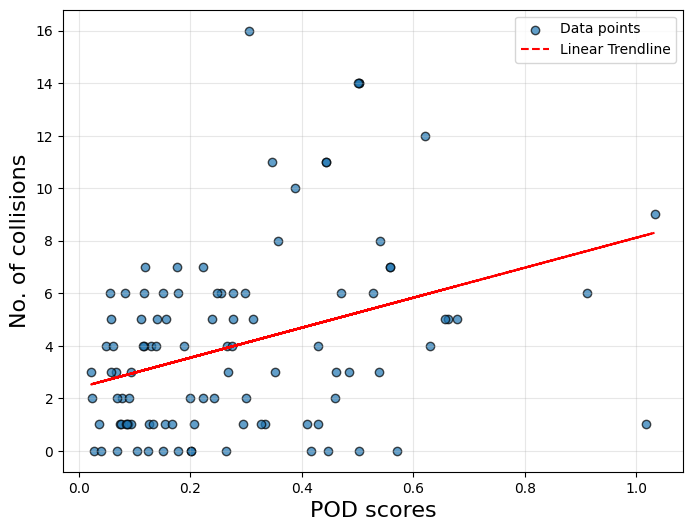

,Method,Correlation,P-Value
0,Pearson,0.123,2.2e-01
1,Spearman,0.100,3.2e-01
2,Kendall,0.081,2.6e-01


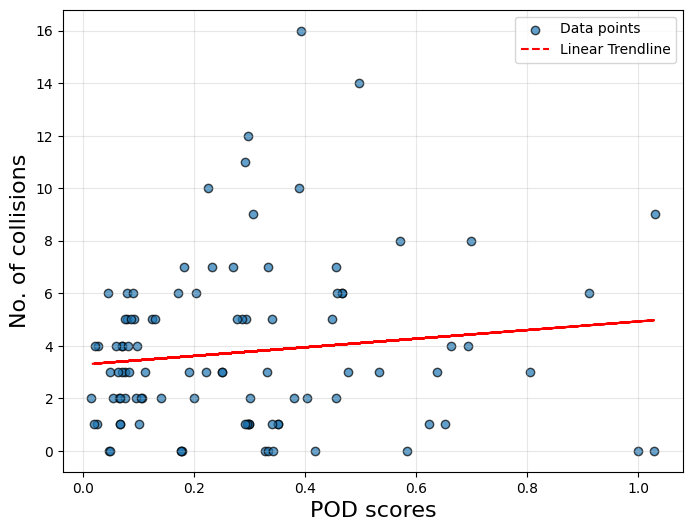

In [35]:
import importlib 
import plot_all
plot_all = importlib.reload(plot_all)
plot_all.main()